# RegionMapper

The goal of this notebook is to describe how regionmapper was developed and how to use it.
After identifying CD13+ and OPN+ regions, we can make a map which will be used to identify to which region each cilia belongs to.

For this, the notebook will be divided into the following steps:

- [Segment CD13](#segment-cd13)
- [Segment OPN](#segment-opn)

## Segment CD13

The goal of this notebook is to explain how CD13 segmentation was developed and how it should be working.

In [2]:
import napari
from pathlib import Path

from morphocilia.io import load_rescaled_channel

c:\Users\agucor\Anaconda3\envs\morphocilia\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
DATA_DIR = Path("../data/20231025_p1_cd13_opn_arl13b.lif")

In [17]:
cd13_channel = load_rescaled_channel(DATA_DIR, "pos2_zstack", 3)

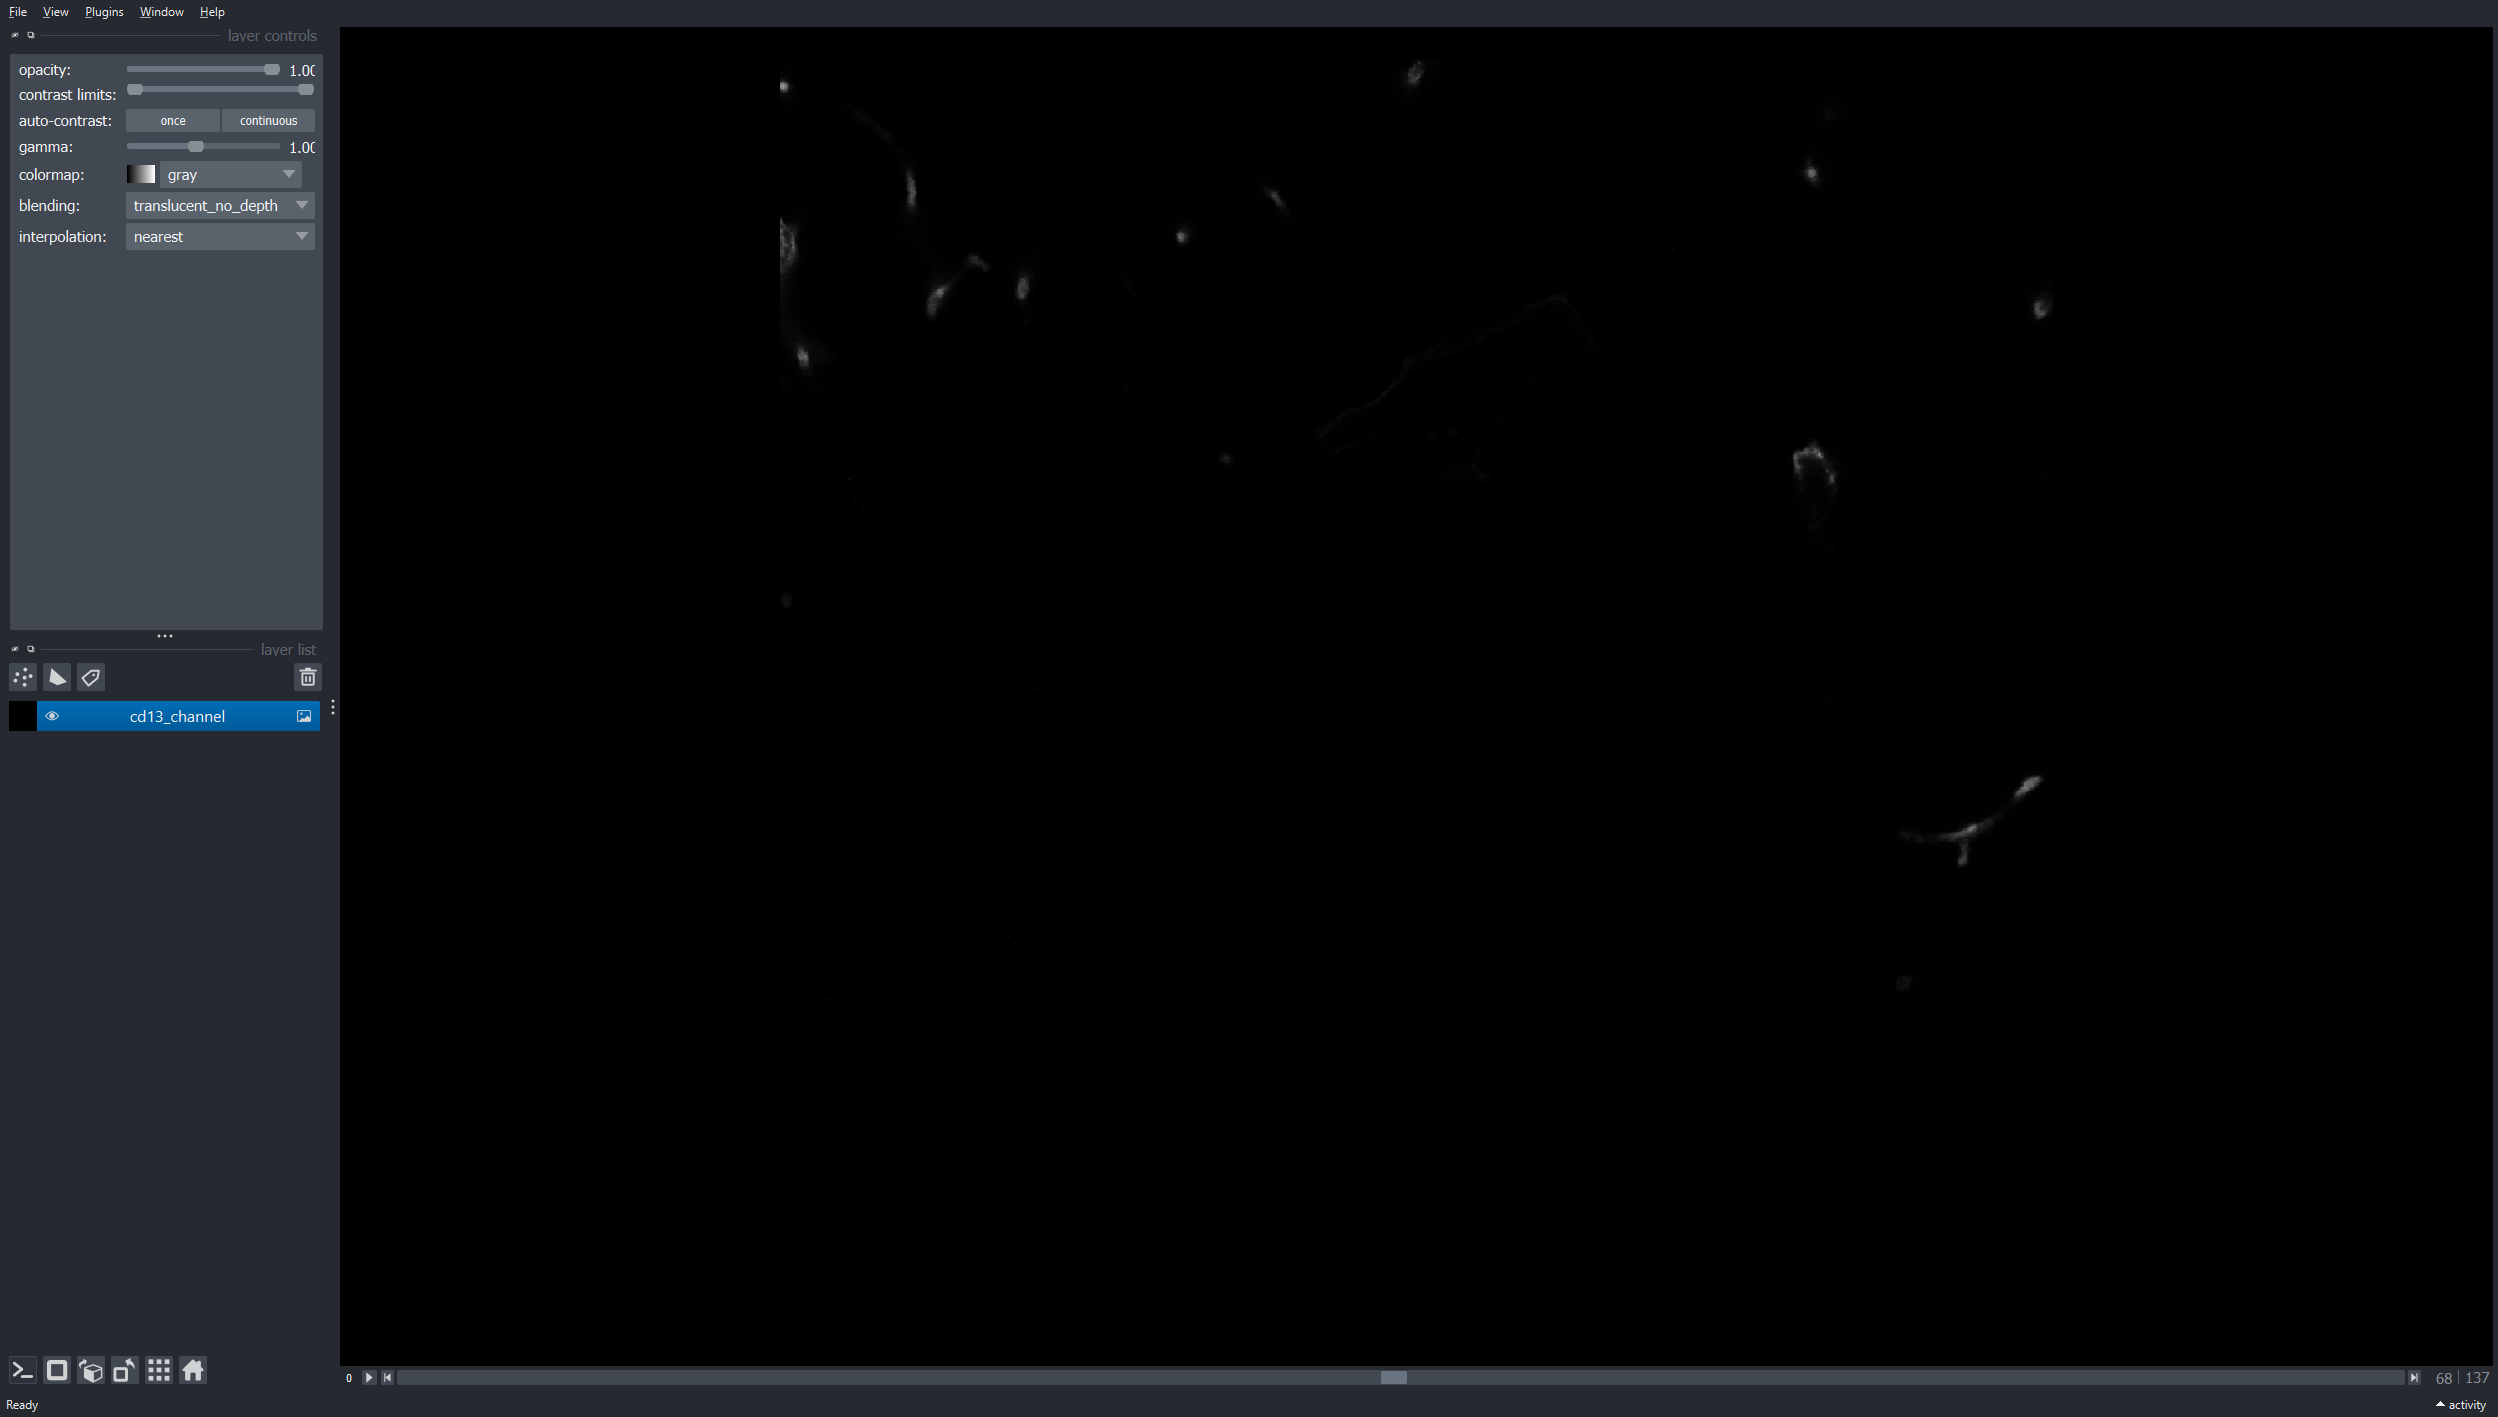

In [21]:
viewer = napari.view_image(cd13_channel)

napari.utils.nbscreenshot(viewer)

It looks like a good way of dealing with these images might be to segment them according to intensity. 
Let's try with several thresholding algorithms and see which one works better.

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

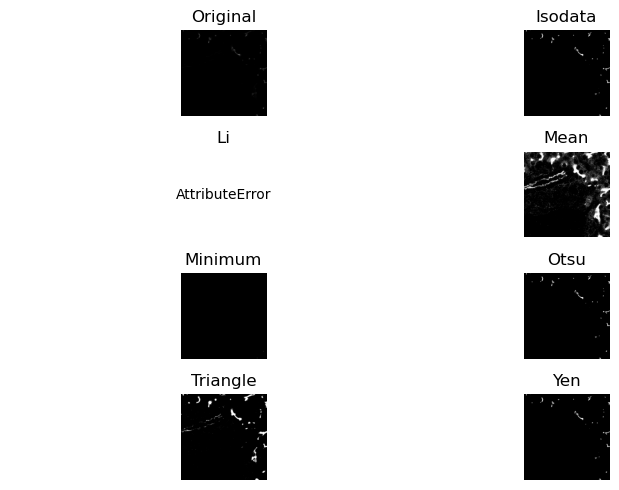

In [20]:
from skimage.filters import try_all_threshold

try_all_threshold(cd13_channel[30])

We have to be careful on how we interpret these results as these algorithms rely on the intensity histogram of the image and as we have used a single plane, the histogram is probably different than what would happen if we use the whole stack.
Already by seeing these images, we can have some estimate of which algorithms are the first we should try out and we can quickly assess them using Napari for visualization.

In [30]:
from skimage.filters import threshold_otsu

In [31]:
cd13_threshold = threshold_otsu(cd13_channel)
cd13_mask = cd13_channel > cd13_threshold

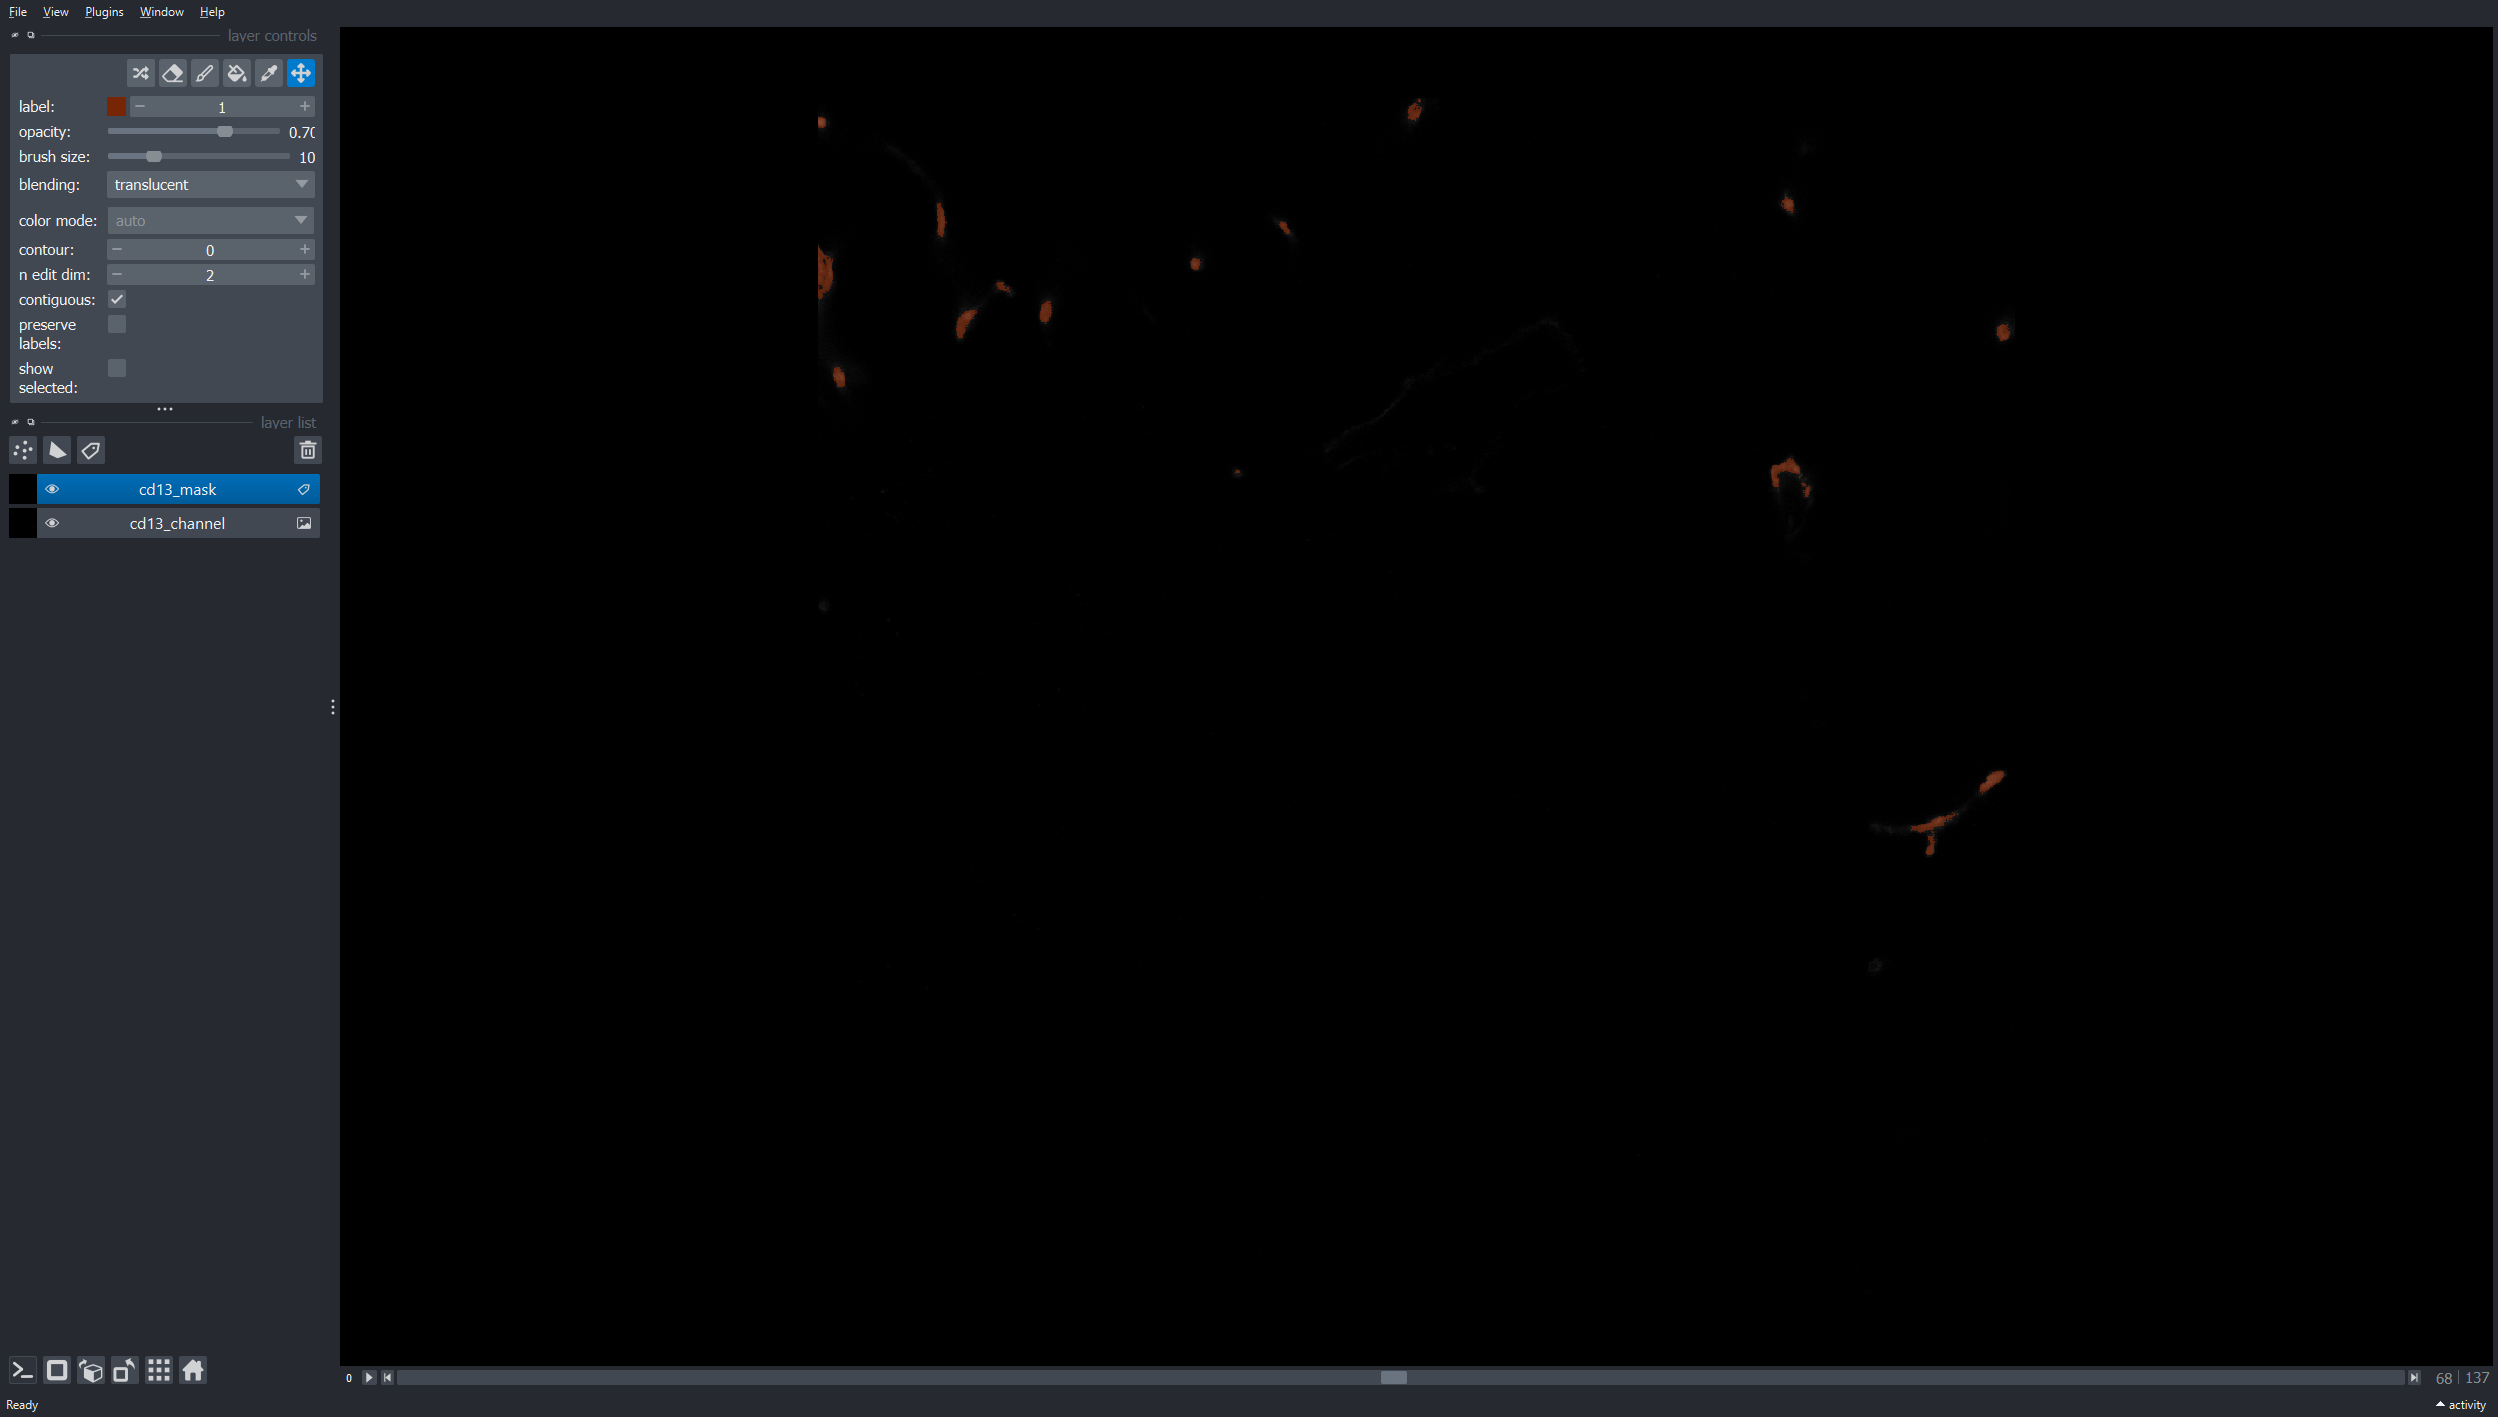

In [32]:
viewer = napari.view_image(cd13_channel)
viewer.add_labels(cd13_mask)

napari.utils.nbscreenshot(viewer)

I first tried triangle, but it was segmenting even very dim pixels and glow surrounding objects.
Otsu thresholding worked the best.
It actually looks so good that there's probably no need to apply morphological operations afterwards to improve this.

## Segment OPN

Following, we will look into Osteopontin segmentation.
We could already go for the same strategy as the quality is similar.

In [4]:
opn_channel = load_rescaled_channel(DATA_DIR, "pos2_zstack", 2)

In [6]:
opn_threshold = threshold_otsu(opn_channel)
opn_mask = opn_channel > opn_threshold

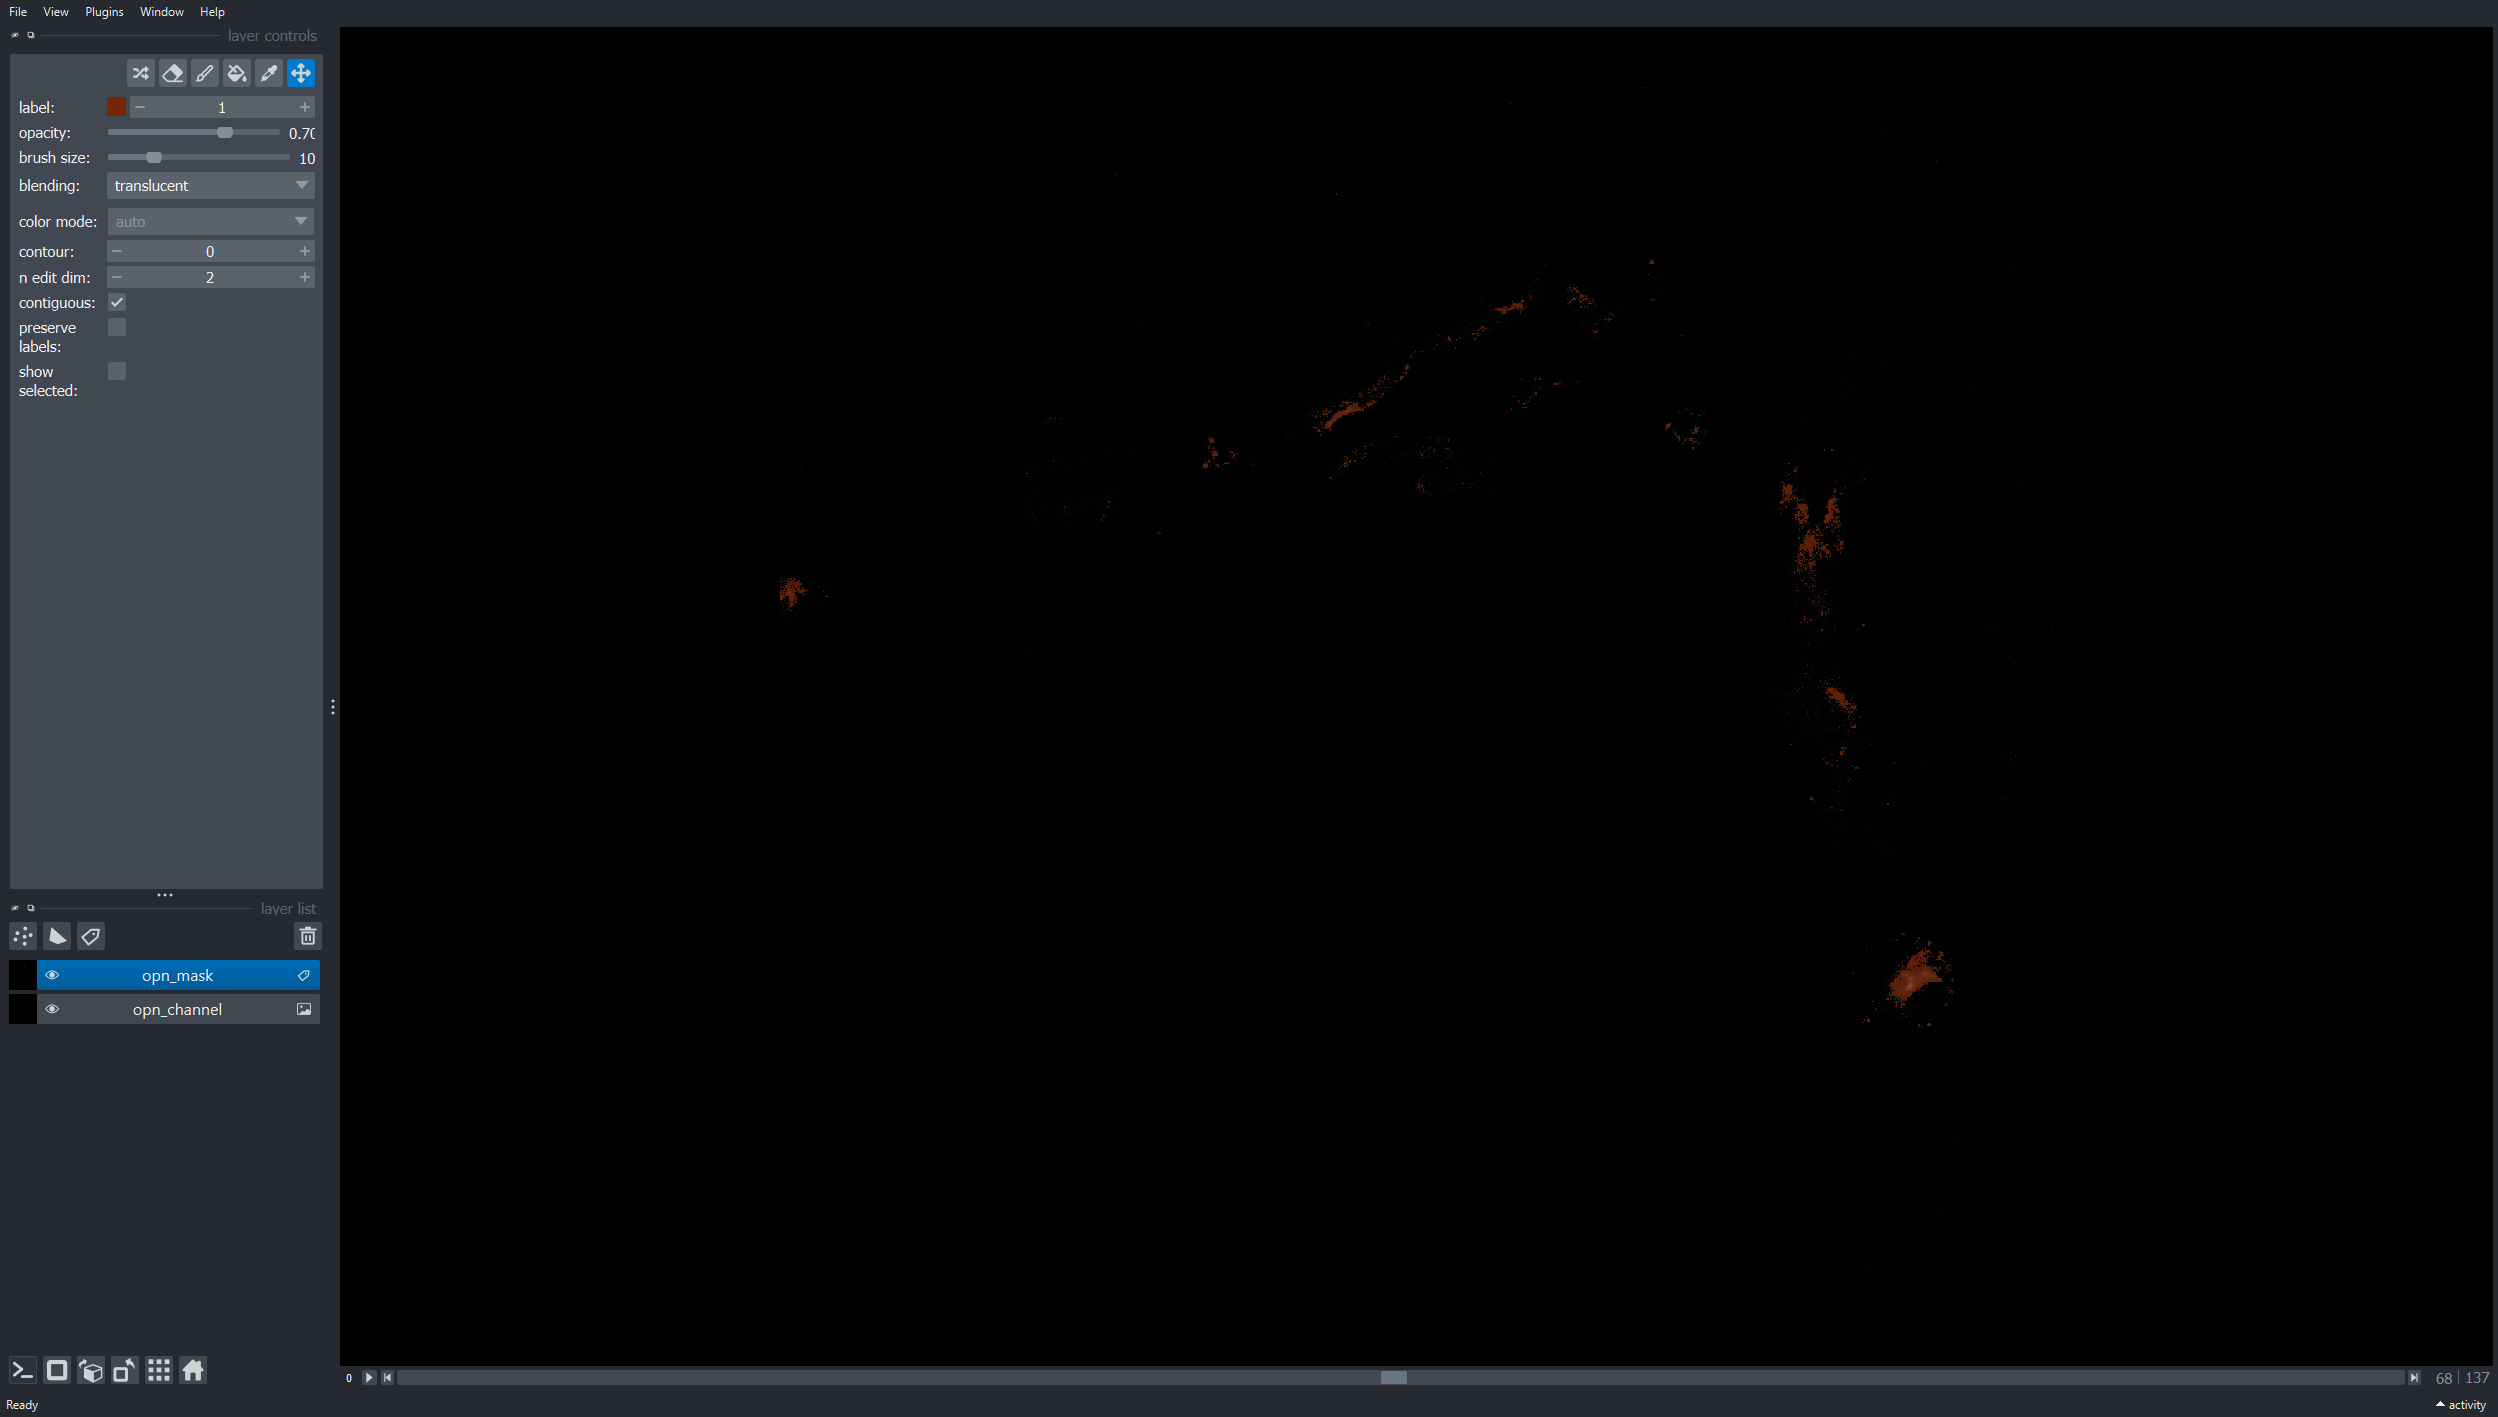

In [7]:
viewer = napari.view_image(opn_channel)
viewer.add_labels(opn_mask)

napari.utils.nbscreenshot(viewer)

This time, there is a bit omre noise in its segmentation.
It mostly looks like it is too dim and it's a bit salty.
We could apply a dilation followed by an erosion, which would be a closing operation.

In [12]:
from skimage.morphology import binary_dilation

In [13]:
polished_opn_mask = binary_dilation(opn_mask)

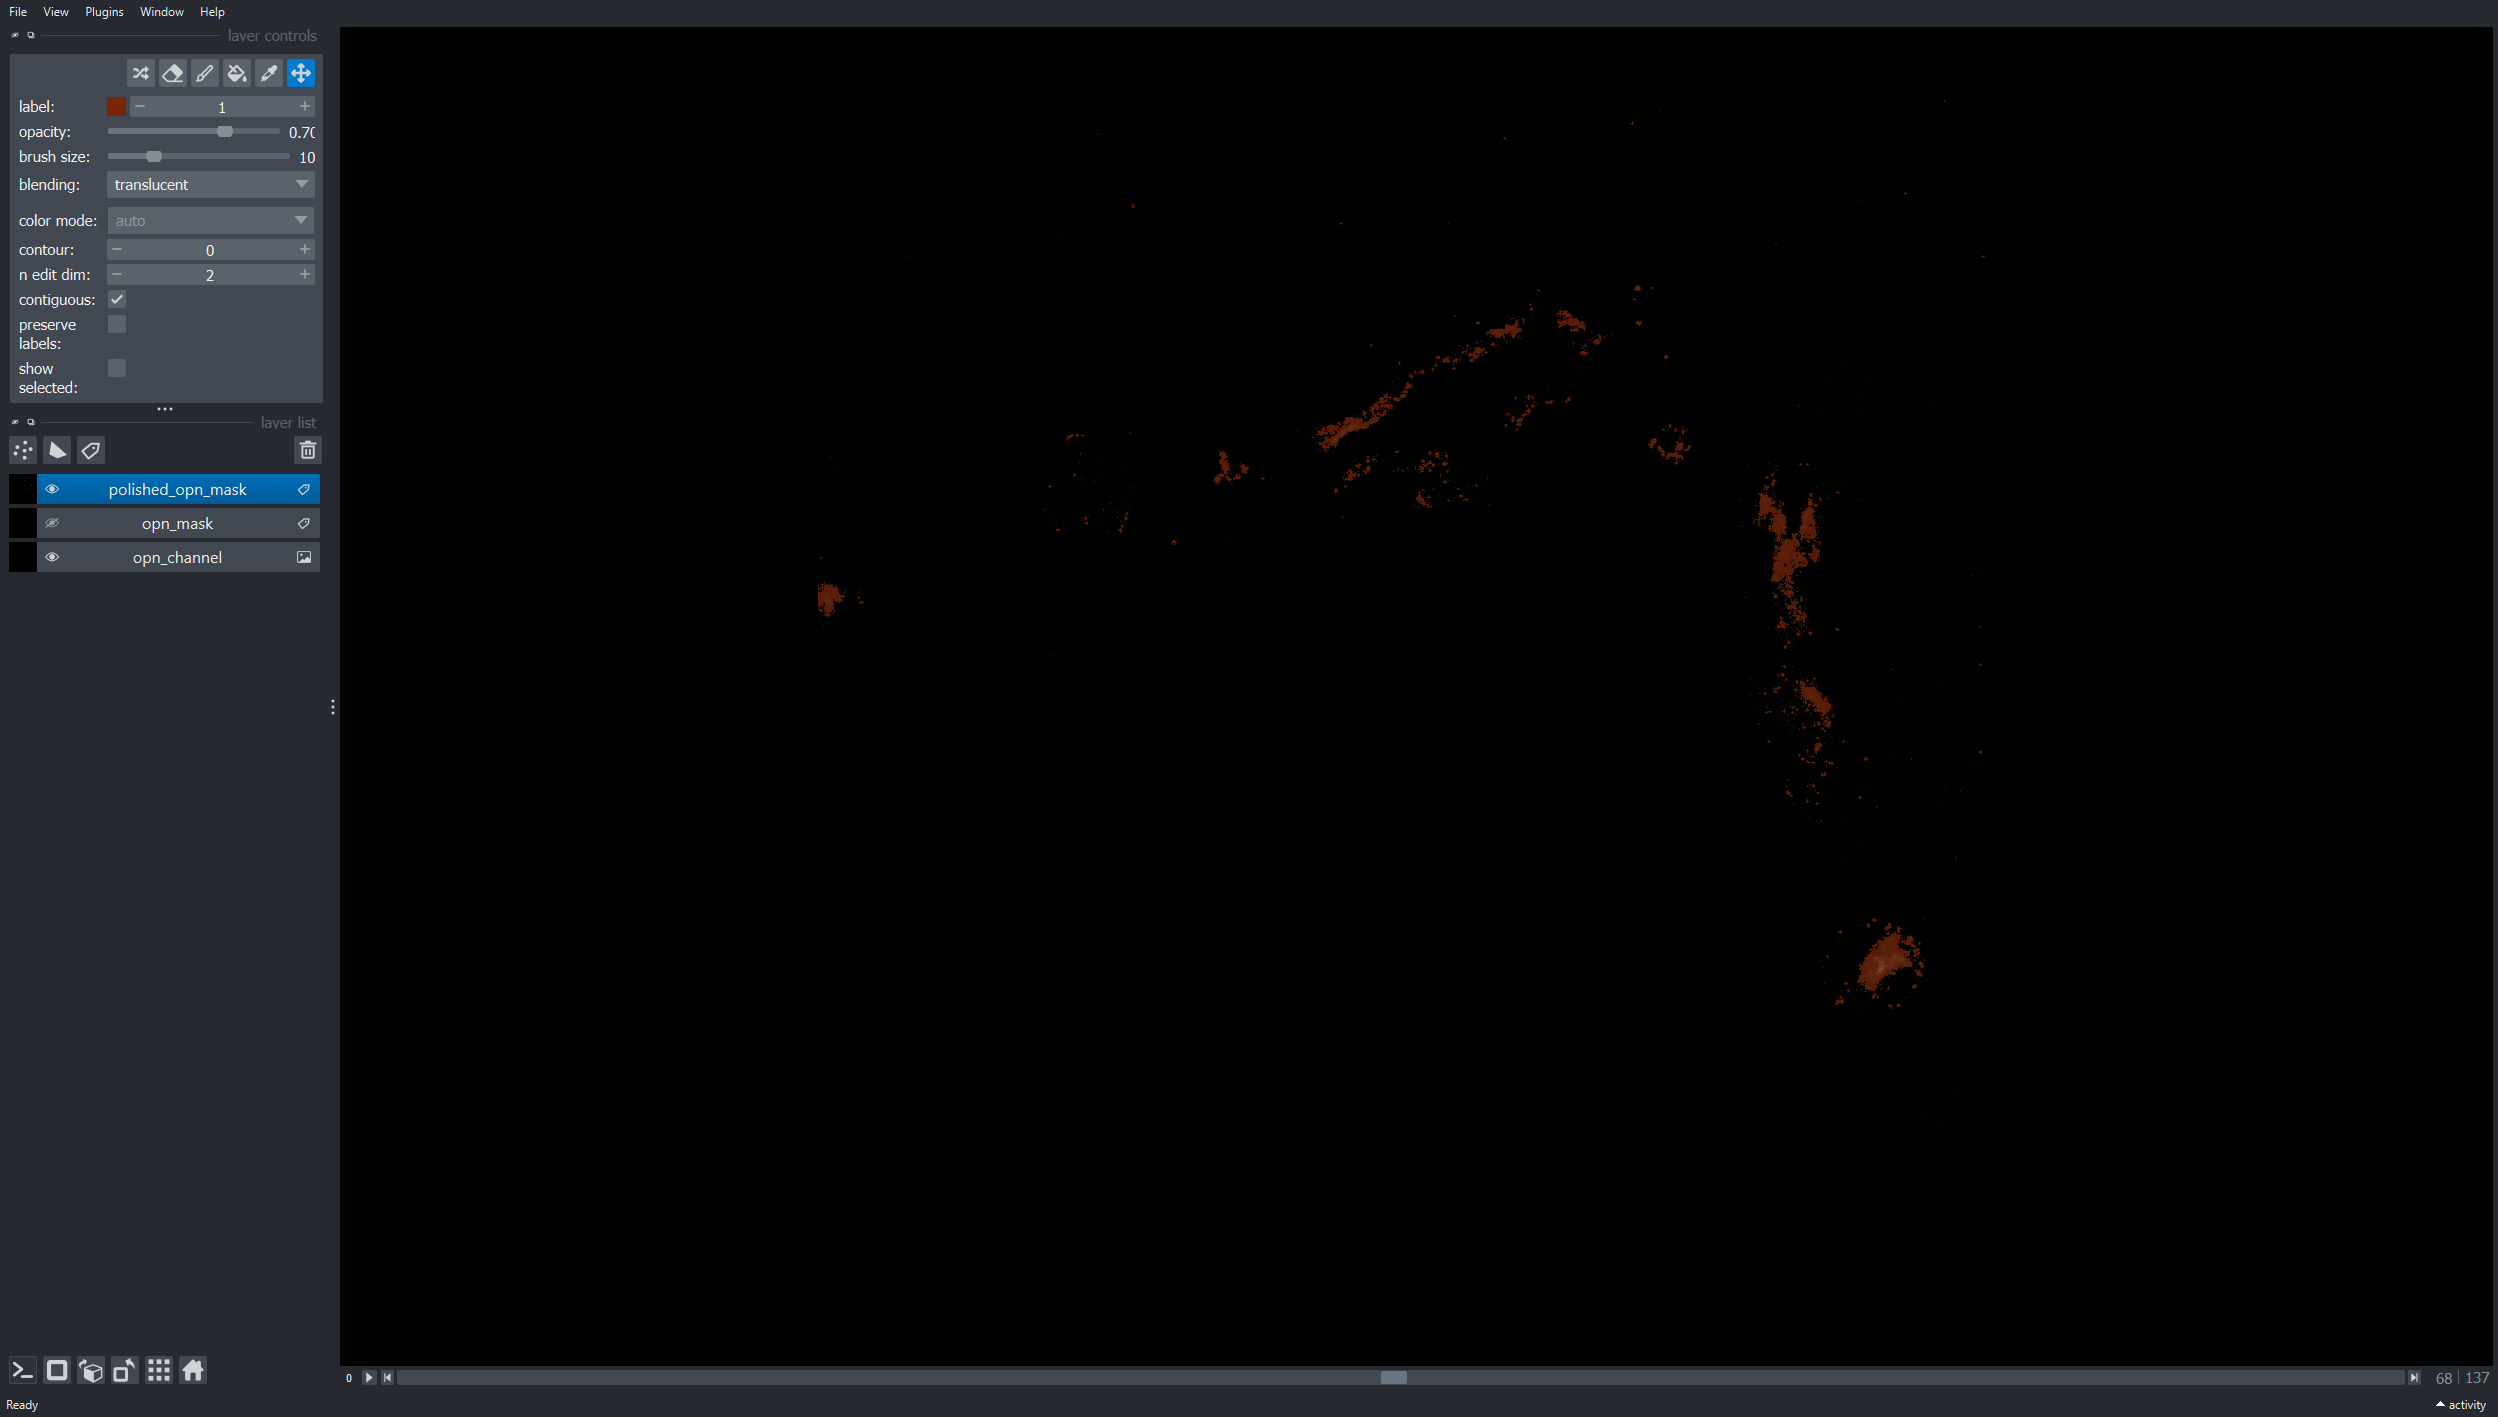

In [15]:
viewer = napari.view_image(opn_channel)
viewer.add_labels(opn_mask, visible=False)
viewer.add_labels(polished_opn_mask)

napari.utils.nbscreenshot(viewer)

Considering that our goal is to find the specific regions, this looks good enough.